<a href="https://colab.research.google.com/github/stunnedbud/CursoRedesProfundas/blob/main/Tarea_1_Ejercicio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1 Ejercicio 4. Red completamente conectada con PyTorch

El objetivo de este ejercicio es implementar una red densa en PyTorch para la clasificación del conjunto de datos FashionMNIST. Este conjunto consiste en 60 mil ejemplos de entrenamiento y 10 mil ejemplos de prueba, donde cada ejemplo es una imagen en escala de grises de tamaño 28 x 28, asociada a una de las siguientes 10 clases:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |  

<br>
<img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png" width="600"/>  <br>
Ejemplos del conjunto FashionMNIST. Imagen tomada de GitHub.

## 1 Preparación

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1.1 Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm.auto import trange

### 1.2 Auxiliares

In [3]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 2, 2 # 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # denormalizamos [0, 1] => [0, 255]
    x *= 255
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # aplanamos canal
    x = x.reshape(*x.shape[:3])
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## 2 Datos

### 2.1 Tuberias de datos con PyTorch

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/f79e17e7aaf27b8c2cbae98c947a33b347ff0e8a/figs/mnist_tuberia.svg" width="1050"/>
&nbsp;
Tuberia de datos para MNIST. La arquitectura del modelo para FashionMNIST es idéntica.

### 2.2 Exploración

PyTorch provee la clase FashionMNIST, una implementación de `Dataset` lista para usar del conjunto FashionMNIST.

In [4]:
# creamos un Dataset
ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # convertir la imagen a ndarray
    transform=np.array,
    # descargar el conjunto
    download=True
)

images[0] shape=(28, 28) dtype=uint8


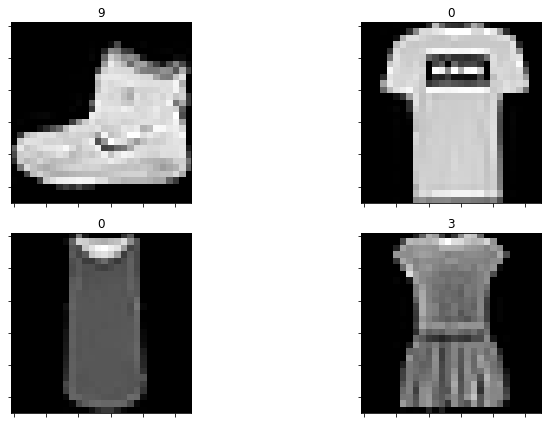

In [5]:
# cargamos algunas imágenes
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

### 2.3 Cargadores de datos

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/eval_trn_tst.svg" width="470"/>

&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

#### Entrenamiento

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


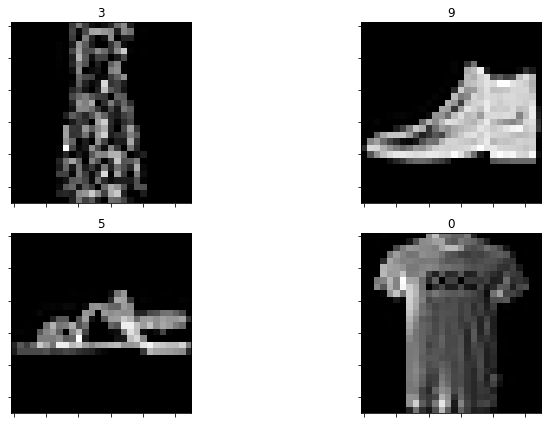

In [6]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

#### Prueba

x shape=torch.Size([32, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


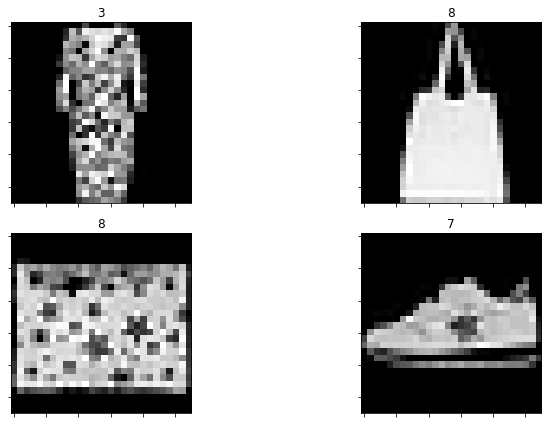

In [7]:
# creamos un Dataset
tst_ds = FashionMNIST(
    # directorio de datos
    root=DATA_DIR, 
    # queremos el subconjunto de prueba
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, y.tolist(), ROWS, COLS)

## 3 Modelo

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/fc_arch.svg" width="800"/>
&nbsp;
Arquitectura de la red completamente conectada.

### 3.1 Definición de la arquitectura

In [8]:
# definición del modelo
class FCN(nn.Module):

    # inicializador
    def __init__(self):

        # inicilización del objeto padre, obligatorio
        super().__init__()

        # tamaño de las capas
        self.I = 1 * 28 * 28
        FC1, FC2, FC3, FC4 = 128, 256, 128, 10

        # definición de capas
        self.cls = nn.Sequential(
            # aplanamos la matriz de píxeles a un vector
            # [N, 1, 28, 28] => [N, 1x28x28]
            nn.Flatten(),
            # fc1
            # [N, 1x28x28] => [N, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            # fc2
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            # fc3
            nn.Linear(FC2, FC3),
            nn.ReLU(),
            # fc4
            # [N, 128] => [N, 10]
            nn.Linear(FC3, FC4)
        )

    # método para inferencia
    def forward(self, x):
        # [N, 1x28x28]
        x = self.cls(x)
        return x

### 3.2 Instancia de la arquitectura

In [9]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): ReLU()
    (7): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [10]:
# inferencia con datos sintéticos
x = torch.zeros(1, 1, 28, 28)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 28, 28]) => torch.Size([1, 10])


### 3.3 Inspección de la arquitectura

In [11]:
summary(model, (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN                                      [1, 28, 28]               [1, 10]
├─Sequential: 1-1                        [1, 28, 28]               [1, 10]
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─ReLU: 2-3                         [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 256]
│    └─ReLU: 2-5                         [1, 256]                  [1, 256]
│    └─Linear: 2-6                       [1, 256]                  [1, 128]
│    └─ReLU: 2-7                         [1, 128]                  [1, 128]
│    └─Linear: 2-8                       [1, 128]                  [1, 10]
Total params: 167,690
Trainable params: 167,690
Non-trainable params: 0
Total mult-adds (M): 0.17
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Param

## 4 Entrenamiento

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/dbf3441f7d73c5cccada48d9813636e5b083a487/figs/supervisado.svg" width="800"/>
&nbsp;
Ciclo de entrenamiento supervisado.

### 4.1 Ciclo de entrenamiento

In [12]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

Entrenamos un modelo:

In [13]:
# instanciamos un modelo
model = FCN()
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  0%|          | 0/20 [00:00<?, ?it/s]

E00 loss=[226.85,226.87] acc=[10.17,10.18]
E01 loss=[212.67,212.76] acc=[40.53,39.94]
E02 loss=[156.59,157.02] acc=[45.79,44.94]
E03 loss=[120.15,120.81] acc=[59.58,58.76]
E04 loss=[101.58,102.65] acc=[63.03,62.17]
E05 loss=[ 89.71, 91.09] acc=[65.54,64.48]
E06 loss=[ 82.39, 83.79] acc=[68.44,67.35]
E07 loss=[ 77.59, 79.30] acc=[69.51,68.49]
E08 loss=[ 73.73, 75.50] acc=[72.36,71.33]
E09 loss=[ 70.83, 72.79] acc=[74.07,73.12]
E10 loss=[ 68.25, 70.31] acc=[74.39,73.48]
E11 loss=[ 65.99, 68.11] acc=[76.11,74.84]
E12 loss=[ 64.02, 66.31] acc=[77.42,76.34]
E13 loss=[ 62.09, 64.57] acc=[77.97,76.78]
E14 loss=[ 60.30, 62.72] acc=[78.51,77.15]
E15 loss=[ 58.81, 61.25] acc=[79.22,77.97]
E16 loss=[ 57.34, 59.94] acc=[79.92,78.45]
E17 loss=[ 56.56, 59.35] acc=[80.46,78.67]
E18 loss=[ 55.51, 58.21] acc=[80.78,79.31]
E19 loss=[ 54.32, 57.08] acc=[81.25,79.84]


### 4.2 Gráficas de pérdidas y exactitud

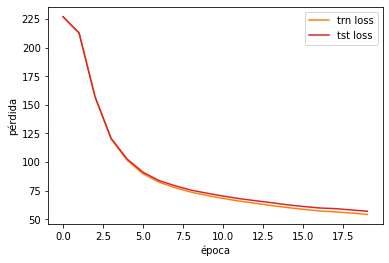

In [14]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

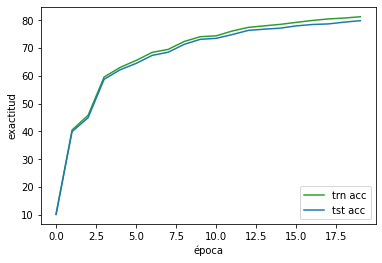

In [15]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## 5 Evaluación

<img src="https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/2077b80363cfac8204826cb48b8ed51a5a41770e/figs/eval_trn_tst.svg" width="470"/>
&nbsp;
Entrenamiento con una partición de entrenamiento y prueba.

### 5.1 Evaluación final

In [16]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[ 54.32, 57.11] acc=[81.25,79.85]


### 5.2 Inferencia

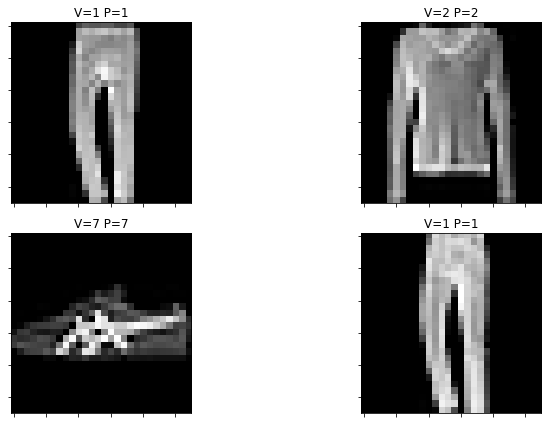

In [17]:
with torch.no_grad(): 
    x, y_true = next(iter(tst_dl))
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

## 6. Discusión

El conjunto FashionMNIST fue propuesto como reemplazo de MNIST, pues los autores consideran que MNIST es muy fácil: incluso los modelos "básicos" de redes neuronales artificiales logran desempeños de 97% rápidamente, por lo que argumentan no es útil como benchmark para evaluar el desempeño de los modelos más modernos. Más aún, [parece que basta 1 pixel para diferenciar entre pares de dígitos en MNIST](https://gist.github.com/dgrtwo/aaef94ecc6a60cd50322c0054cc04478). 

Debido a ésto yo inicialmente esperaba que la misma red usada para clasificar MNIST tuviera un desempeño mucho peor en FashionMNIST, pero afortunadamente no fue el caso. Para poder compararlas directamente, se probó el desempeño del modelo bajo los mismos hiperparámetros y arquitectura que se ocupó para MNIST. En las siguientes figuras podemos ver que en FashionMNIST la curva de pérdida en el conjunto de prueba y entrenamiento es bastante parecida a la obtenida en MNIST. En cuanto a la exactitud sí le fue algo peor en FashionMNIST, llegando a un valor cercano de 73% en el conjunto de prueba mientras que en MNIST llegó a 84%, pero no le fue nada mal considerando el incremento en dificultad comparado con MNIST.

  - MNIST:   
    <img src="https://drive.google.com/uc?id=1GgjpHwlmQ15jrz7IvghW9MB8Ua-YlSNV"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1ih0vOS_jTENaFZUI9oXBzbeWfQozrF6d" width="400"/>  
        min loss=[ 73.11, 71.36] best accuracy=[83.81,84.33]  

  - FashionMNIST:   
    <img src="https://drive.google.com/uc?id=19LUeNGhOQMswBQPoi99DHTFB_gj8sq2t"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1dTFzne5F553nDSB6X4bEot10OHZi3GZ6" width="400"/>  
        min loss=[ 80.31, 81.51] best accuracy=[74.12,73.26]  

## 7. Variaciones

Para ver más claramente el efecto de cambiar cada hiperparámetro o característica de la red, se probaron distintas versiones del modelo cambiando solamente uno de los atributos a la vez.

### 7.1 Hiperparámetros
- **Tamaño de lote**. Se probaron los siguientes valores: 64, 32, 16, 8, y 4. Se vió un desempeño considerablemente mejor con tamaños de lote muy pequeños, aunque los modelos con tamaño 8 y 4 tardaron bastante más tiempo en entrenarse. Para este conjunto de datos la mejor precisión se logró con tamaño 4, mejorando hasta llegar a 80%. A continuación se muestran las gráficas de pérdida y precisión para cada instancia probada, así como el mejor valor obtenido:

  - Tamaño de lote = 64    
    <img src="https://drive.google.com/uc?id=1kqWkhMLHfMtTwDgxEnMRNt7TY7ktddHo"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=11m-CQYZf0CJ3h_Qql5vGwta9djJiK-sW" width="400"/>  
        min loss=[110.12,111.02] best accuracy=[69.78,68.91]  

  - Tamaño de lote = 32  
    <img src="https://drive.google.com/uc?id=19LUeNGhOQMswBQPoi99DHTFB_gj8sq2t"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1dTFzne5F553nDSB6X4bEot10OHZi3GZ6" width="400"/>  
        min loss=[ 80.31, 81.51] best accuracy=[74.12,73.26]  

  - Tamaño de lote = 16  
    <img src="https://drive.google.com/uc?id=15QKIMqDGOGLVRpq4ubaFdK186RUde3Mp"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1ljkbOSZe5XZuKZ-QXgtPPXalcqfguJbs" width="400"/>  
        min loss=[ 63.39, 65.09] best accuracy=[77.69,76.76]  

  - Tamaño de lote = 8  
    <img src="https://drive.google.com/uc?id=1o4UMup4lf6Yi-Efy7MjVmKZAM7i6HvJo"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1OY_JMfmfM8iUBjhEk9jem_6ZzGzQ4B04" width="400"/>  
        min loss=[ 52.33, 54.67] best accuracy=[81.61,80.49]  

  - Tamaño de lote = 4  
    <img src="https://drive.google.com/uc?id=1tWUb9Luo77_sAYYsY6LcZERPX2CngR1K"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1BJkkzmwVj1N9jxv0vWYkm9TVA4wv4EUE" width="400"/>  
        min loss=[ 44.98, 48.10] best accuracy=[84.23,82.80]

<hr>

- **Tasa de aprendizaje**. Se probaron los siguientes valores: 1e-4, 1e-3, 1e-2, y 1e-1. En esta ocasión se obtuvo una mejor precisión con una tasa de aprendizaje más alta, con lr = 1e-1 se obtuvo una precisión de 87% en el conjunto de prueba, sin embargo las curvas de los conjuntos de aprendizaje y prueba se empiezan a separar, lo que puede indicar un sobreajuste.

  - Tasa: 1e-4    
    <img src="https://drive.google.com/uc?id=1lN5P-UkbKx0QsKMuSYrrWvbLZQ8LOJuG"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1Li2tUarnnNTNP_CKqqWaEuyKqBAe44Dc" width="400"/>  
        min loss=[205.38,205.50] best accuracy=[60.17,59.79]  

  - Tasa: 1e-3    
    <img src="https://drive.google.com/uc?id=1tWUb9Luo77_sAYYsY6LcZERPX2CngR1K"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1BJkkzmwVj1N9jxv0vWYkm9TVA4wv4EUE" width="400"/>  
        min loss=[ 44.98, 48.10] best accuracy=[84.23,82.80]  

  - Tasa: 1e-2    
    <img src="https://drive.google.com/uc?id=1JMEPFU4btzMVTE9s38SBZYRM4DD-CL7U"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1ibM4WugujPnsWNfjlcgU8eYQTzyTVJKI" width="400"/>  
        min loss=[ 43.13, 46.46] best accuracy=[84.77,83.46]  

  - Tasa: 1e-1     
    <img src="https://drive.google.com/uc?id=1drEr6dIkp5B-48N7_3Y_AqJC3jRncwkH"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1K2fBqwdOFDHcDx7h8K7yhlP8kbUYQp7X" width="400"/>  
        min loss=[ 27.90, 35.03] best accuracy=[89.91,87.53]  

<hr>

- **Número de épocas**. Habiendo identificado los mejores valores (o al menos los mejores de los intentados) para tasa de aprendizaje y tamaño de lote, se probó incrementar el número de épocas de 20 a 50, para ver qué tanto puede mejorar esta versión del modelo. Sin embargo en ésta versión ocurre un muy evidente sobreajuste: las gráficas de los conjuntos de prueba y entrenamiento se separan, y en un punto la de prueba empeora aunque la de entrenamiento sigue mejorando. Aún así, se logró una mejor precisión que todos los modelos anteriores, de 88.67 en el conjunto de prueba. 

    <img src="https://drive.google.com/uc?id=1DrNNrA3cCQ5Zkrn9mg8HfOLYj0Uquf6Q"
 width="400"/>  
    <img src="https://drive.google.com/uc?id=1KBztenT_n_IjY4RG3_yK6ns2uyZRbN-A" width="400"/>  
loss=[ 12.21, 41.94] acc=[95.52,88.67]

### 7.2 Funciones de activación

- **Sigmoide**. Esta es la función de activación que se ha estado usando hasta ahora. Para comparación, estos son los mejores valores de pérdida y precisión obtenidos con batch_size = 32 y lr = 1e-3:

      min loss=[ 80.31, 81.51] best accuracy=[74.12,73.26]  

- **ReLU**. Podemos ver que usar una función de activación ReLU (Rectified Linear Unit) sí mejora considerablemente la precisión obtenida:

      min loss=[ 50.63, 53.35] best accuracy=[82.87,81.65]  


- **Leaky ReLU**. El desempeño de Leaky ReLU es prácticamente idéntico al de ReLU:

      min loss=[ 50.64, 53.36] best accuracy=[82.87,81.62]  

#### 7.2 Número de capas y neuronas
- **Neuronas**. Para ver el efecto de agregar o quitar neuronas, se probaron los valores de 256, 128, y 64 neuronas ocultas en la red con una capa oculta, tamaño de lote de 32 y tasa de aprendizaje 1e-3. No hay cambios significativos resultantes de cambiar este número, incluso duplicar la cantidad de neuronas mejora la precisión en menos de 1%.

   - n = 256

      min loss=[ 77.03, 78.20] best accuracy=[74.44,73.87]

   - n = 128

      min loss=[ 80.31, 81.51] best accuracy=[74.12,73.26]  

   - n = 64

      min loss=[ 84.98, 86.13] best accuracy=[73.20,71.98]  


- **Capas**. Finalmente se probó incrementar el número de capas ocultas. Aquí hay que ser cuidadosos con la función de activación escogida, pues incluso con solo 2 capas ocultas el desempeño de la red con activaciones sigmoides es muy malo, menor a 45%. Esto se debe al desvanecimiento de gradiente, por lo que es mejor usar funciones de activación ReLU. Usando ReLU en una red con 3 capas ocultas el desempeño fue aproximadamente 8% mejor que la red de 1 capa con activación sigmoide.

  - 2 capas ocultas de 128 neuronas cada una y activación sigmoide:    
    <img src="https://drive.google.com/uc?id=1DIMId00gnKX1AVLuB0cJ1OlJZJSU3aiM"
 width="400"/>   
        min loss=[168.61,168.83] best accuracy=[44.74,45.05]  

  
  - 3 capas ocultas de 128, 256, y 128 neuronas respectivamente y activación ReLU:    
    <img src="https://drive.google.com/uc?id=1NcpJo2kpnk96KBVVqlgBWpnXcIqAB9Xb"
 width="400"/>   
        min loss=[ 54.32, 57.11] best accuracy=[81.25,79.85]

